Apple vs Orange Binary Classification

# Data Split

In [ ]:
# 데이터 분리 (train, validation, test)

import os
import shutil
import random

# 원본 폴더
original_dataset_dir = 'dataset'

# 새로 만들 폴더
base_dir = './dataset_split'
os.makedirs(base_dir, exist_ok=True)

# train/val/test 각각 폴더 생성
for split in ['train', 'validation', 'test']:
    for category in ['apple', 'orange']:
        path = os.path.join(base_dir, split, category)
        os.makedirs(path, exist_ok=True)

# 각 클래스별로 파일 분리
for category in ['apple', 'orange']:
    path = os.path.join(original_dataset_dir, category)
    filenames = os.listdir(path)
    random.shuffle(filenames)

    total = len(filenames)
    train_split = int(total * 0.8)
    val_split = int(total * 0.9)

    for idx, fname in enumerate(filenames):
        src = os.path.join(path, fname)

        if idx < train_split:
            dst = os.path.join(base_dir, 'train', category, fname)
        elif idx < val_split:
            dst = os.path.join(base_dir, 'validation', category, fname)
        else:
            dst = os.path.join(base_dir, 'test', category, fname)

        shutil.copyfile(src, dst)

# Baseline CNN

In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 로딩
train_dir = 'dataset_split/train'
val_dir = 'dataset_split/validation'
test_dir = 'dataset_split/test'

# Data Augmentation (Train만 적용)
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Validation, Test (증강 없이)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Baseline CNN 모델 
model_baseline = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # 이진 분류
], name = "BaselineCNN")

model_baseline.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_baseline.summary()

Found 636 images belonging to 2 classes.


Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "BaselineCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# 학습
history = model_baseline.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=30
    )

# 저장(optional)
model_baseline.save('apple_orange_cnn.keras')

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6259 - loss: 0.8746 - val_accuracy: 0.7750 - val_loss: 0.4736
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.8740 - loss: 0.3042 - val_accuracy: 0.8875 - val_loss: 0.2992
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9030 - loss: 0.2775 - val_accuracy: 0.9250 - val_loss: 0.2428
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9491 - loss: 0.1704 - val_accuracy: 0.8875 - val_loss: 0.2375
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9424 - loss: 0.1469 - val_accuracy: 0.9250 - val_loss: 0.1950
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9789 - loss: 0.0793 - val_accuracy: 0.8875 - val_loss: 0.2501
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9802 - loss: 0.0657 - val_accuracy: 0.9000 - val_loss: 0.2772
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9927 - loss: 0.0411 - val_accuracy: 0.8875 - val_

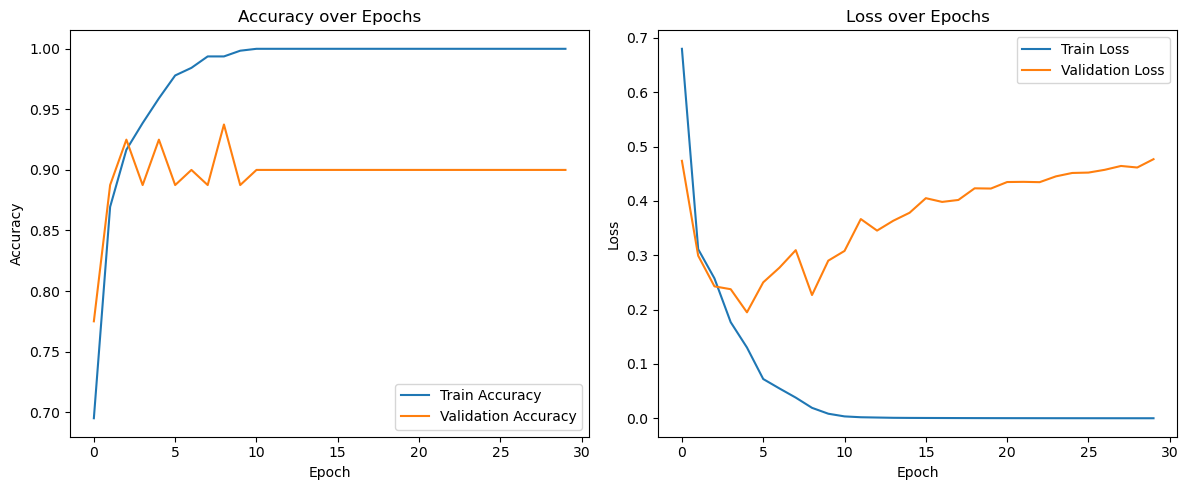

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


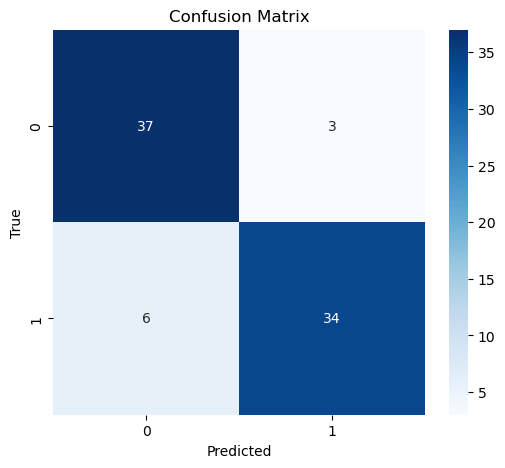


Classification Report:
              precision    recall  f1-score   support

       apple       0.86      0.93      0.89        40
      orange       0.92      0.85      0.88        40

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80



In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy / Loss 그래프
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix & Classification Report
test_generator.reset()
y_pred = model_baseline.predict(test_generator)
y_pred = np.where(y_pred > 0.5, 1, 0).flatten()

# 정답 클래스
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Baseline CNN + Data Augmentation

In [71]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. 데이터 로딩
train_dir = 'dataset_split/train'
val_dir = 'dataset_split/validation'
test_dir = 'dataset_split/test'

# Data Augmentation (Train만 적용)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Validation, Test (증강 없이)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# 3. Baseline CNN 모델 
model_baseline_v2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # 이진 분류
], name = "BaselineCNN2")

model_baseline_v2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_baseline_v2.summary()

Found 636 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "BaselineCNN2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_118 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
history = model_baseline_v2.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=30
    )

# 5. 저장(optional)
model_baseline_v2.save('apple_orange_cnn2.keras')

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5616 - loss: 1.7307 - val_accuracy: 0.7125 - val_loss: 0.6174
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7644 - loss: 0.5050 - val_accuracy: 0.8750 - val_loss: 0.4004
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8507 - loss: 0.3754 - val_accuracy: 0.8375 - val_loss: 0.3955
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.8686 - loss: 0.3712 - val_accuracy: 0.8375 - val_loss: 0.4266
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.8724 - loss: 0.3612 - val_accuracy: 0.8375 - val_loss: 0.4027
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.8451 - loss: 0.3685 - val_accuracy: 0.9000 - val_loss: 0.3050
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9060 - loss: 0.3213 - val_accuracy: 0.9125 - val_loss: 0.2528
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8989 - loss: 0.2625 - val_accuracy: 0.9375 - val_

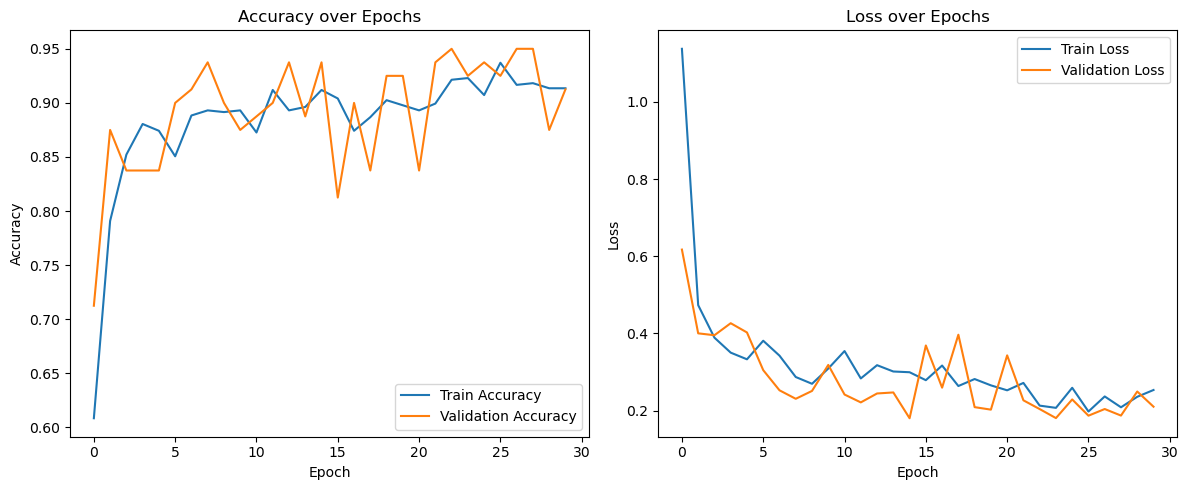

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


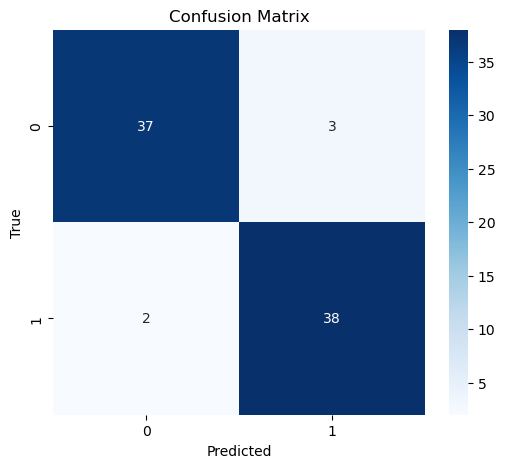


Classification Report:
              precision    recall  f1-score   support

       apple       0.95      0.93      0.94        40
      orange       0.93      0.95      0.94        40

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



In [73]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy / Loss 그래프
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix & Classification Report
test_generator.reset()
y_pred = model_baseline_v2.predict(test_generator)
y_pred = np.where(y_pred > 0.5, 1, 0).flatten()

# 정답 클래스
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# V5

In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 데이터 로딩
train_dir = 'dataset_split/train'
val_dir = 'dataset_split/validation'
test_dir = 'dataset_split/test'

# Data Augmentation (Train만 적용)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Validation, Test (증강 없이)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# 모델 정의 (VGG 스타일)
model_v5 = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    # Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
], name="model_v5")

# 컴파일 (Label Smoothing 적용)
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

model_v5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

# 콜백 설정
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_v5_optimized.keras', monitor='val_accuracy', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# 학습
history = model_v5.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[earlystop, checkpoint, lr_scheduler]
)

# 모델 저장
model_v5.save('apple_orange_vgg_augmented_optimized.keras')

# 테스트셋 최종 평가
test_loss, test_acc = model_v5.evaluate(test_generator)
print(f"최종 Test Accuracy: {test_acc:.4f}")

Found 636 images belonging to 2 classes.


Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 871ms/step - accuracy: 0.5226 - loss: 0.6930 - val_accuracy: 0.5750 - val_loss: 0.6830 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6125 - loss: 0.6581 - val_accuracy: 0.7875 - val_loss: 0.5516 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 933ms/step - accuracy: 0.7362 - loss: 0.5636 - val_accuracy: 0.8625 - val_loss: 0.4110 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 953ms/step - accuracy: 0.8432 - loss: 0.4761 - val_accuracy: 0.9250 - val_loss: 0.3975 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8537 - loss: 0.4548 - val_accuracy: 0.9000 - val_loss: 0.4052 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8961 - loss: 0.4269 - val_accuracy: 0.9000 - val_loss: 0.3726 - learning_rate: 1.0000e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.890

In [58]:
model_v5.summary()

Model: "model_v5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_100 (Conv2D)             │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,308,645 (149.95 MB)

 Trainable params: 13,102,881 (49.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,205,764 (99.97 MB)

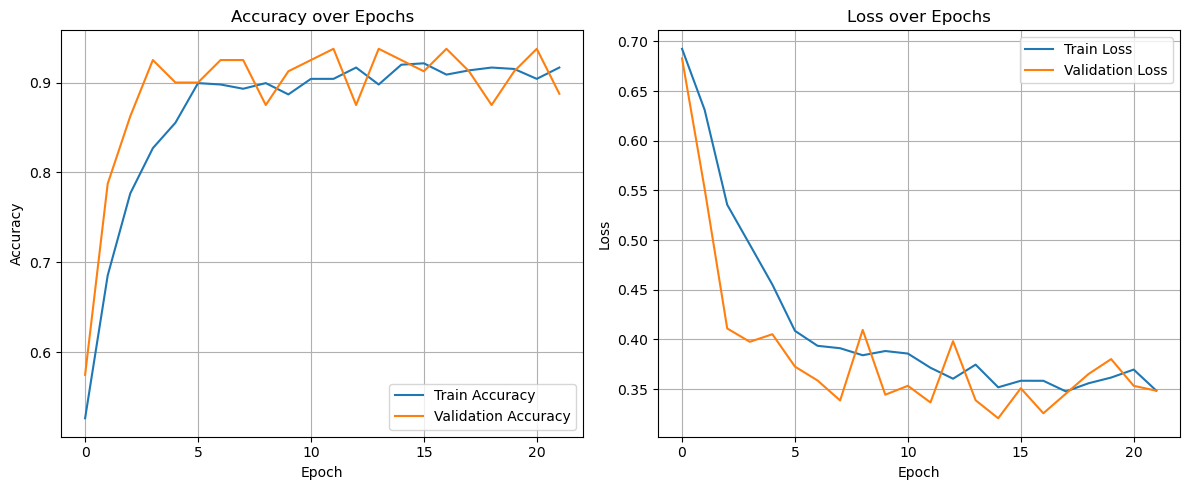

In [60]:
import matplotlib.pyplot as plt

# Accuracy / Loss 그래프 그리기
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 사용
plot_training_history(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


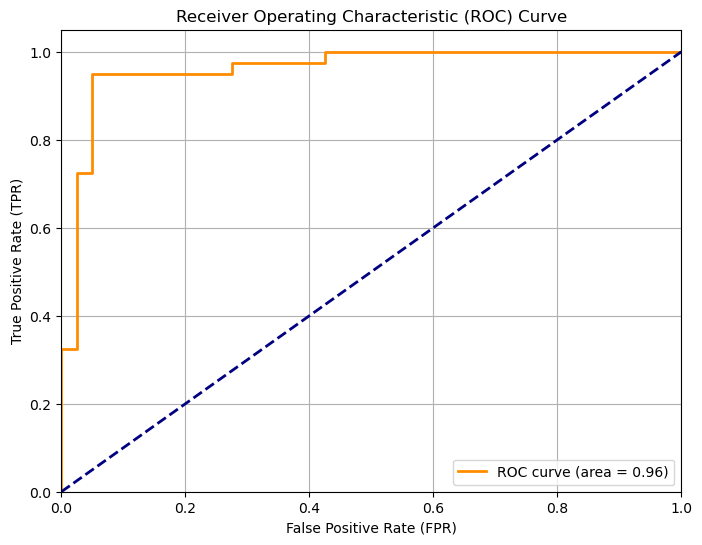

In [61]:
from sklearn.metrics import roc_curve, auc

# 예측 (확률 값 그대로 사용)
test_generator.reset()
y_score = model_v5.predict(test_generator).ravel()  # flatten

# 실제 값
y_true = test_generator.classes

# 1. FPR, TPR 계산
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# 2. AUC 계산
roc_auc = auc(fpr, tpr)

# 3. ROC 곡선 시각화
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


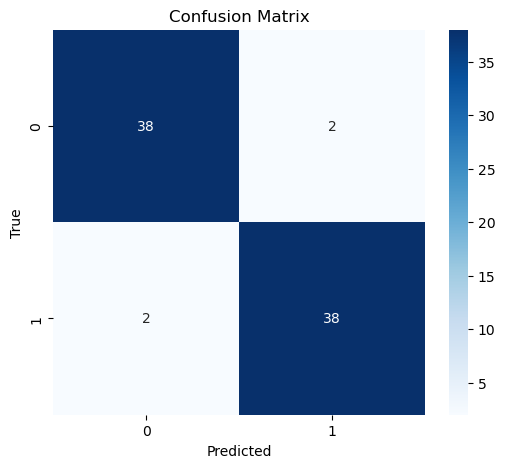


Classification Report:
              precision    recall  f1-score   support

       apple       0.95      0.95      0.95        40
      orange       0.95      0.95      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 예측
test_generator.reset()
y_pred = model_v5.predict(test_generator)
y_pred = np.where(y_pred > 0.5, 1, 0).flatten()

y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
정분류 수: 76개
오분류 수: 4개


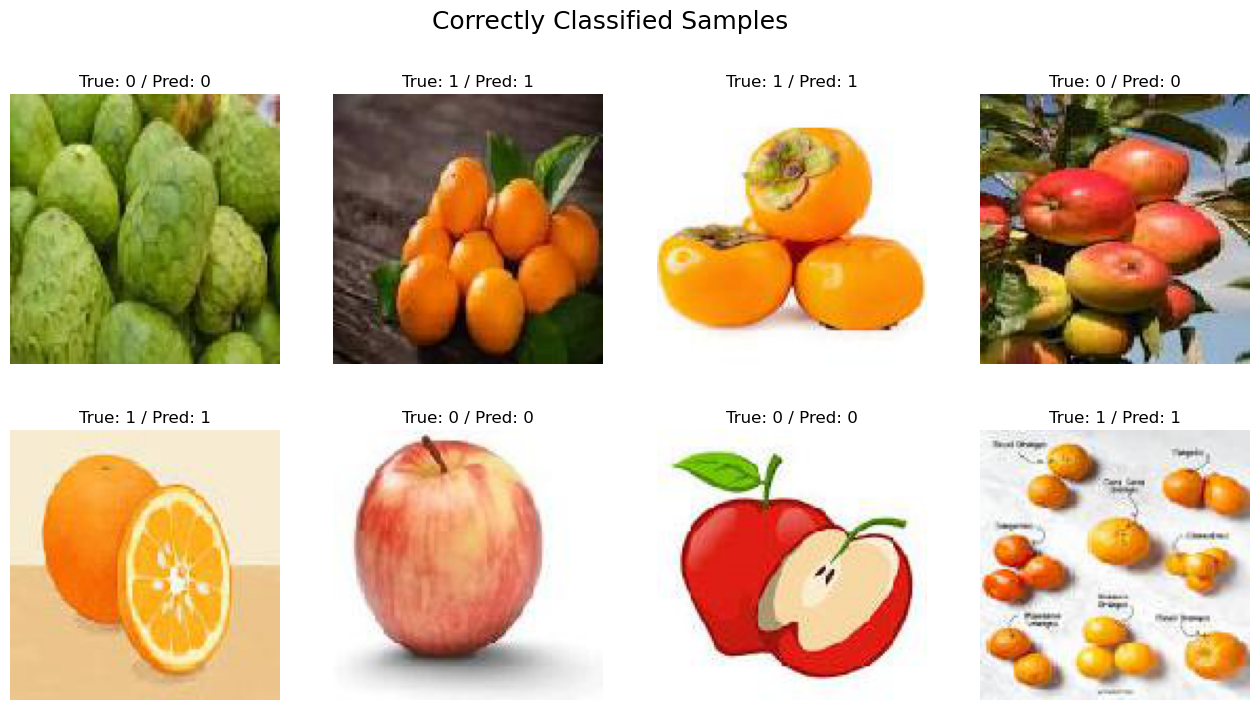

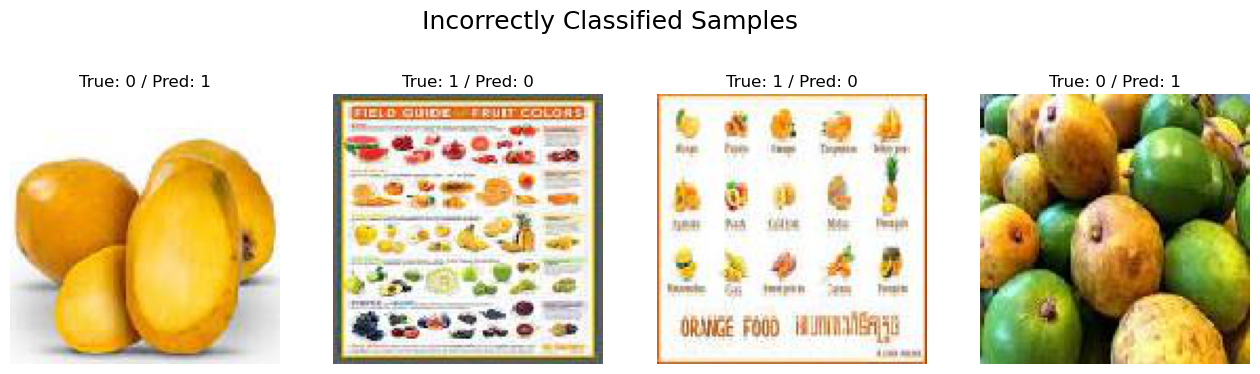

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# 예측 (확률로)
test_generator.reset()
y_score = model_v5.predict(test_generator).ravel()
y_pred = np.where(y_score > 0.5, 1, 0)

# 실제 정답
y_true = test_generator.classes
filepaths = np.array(test_generator.filepaths)

# 정분류(True Positive, True Negative) 인덱스
correct_indices = np.where(y_true == y_pred)[0]

# 오분류(False Positive, False Negative) 인덱스
incorrect_indices = np.where(y_true != y_pred)[0]

print(f"정분류 수: {len(correct_indices)}개")
print(f"오분류 수: {len(incorrect_indices)}개")

# 정분류 중 무작위 샘플 N개
n_samples = 8
random_correct_idx = np.random.choice(correct_indices, size=min(n_samples, len(correct_indices)), replace=False)

# 오분류 중 무작위 샘플 N개
random_incorrect_idx = np.random.choice(incorrect_indices, size=min(n_samples, len(incorrect_indices)), replace=False)

# 시각화 함수
def plot_samples(indices, title):
    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(indices):
        img = plt.imread(filepaths[idx])
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"True: {y_true[idx]} / Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=18)
    plt.show()

# 1. 정분류 샘플
plot_samples(random_correct_idx, title="Correctly Classified Samples")

# 2. 오분류 샘플
plot_samples(random_incorrect_idx, title="Incorrectly Classified Samples")